In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import integrate
import sympy as sm
from IPython.display import display, Math
import os
import math

In [2]:
output_fold = os.getcwd() + r'\output'

In [3]:
# Parameters derived from the literature (see report)
K = 1000  # Carrying capacity
b = 9  # Intrinsic female laying rate per day
m = 0.5  # Sex ratio
vL = 1 / 12.8  # Larvae to adult transfer rate
vF = 1 / 1.5  # Virgin to fertilized transfer rate
uL = 0.12  # 12% Larval mortality rate
uM = 0.11 #1-np.log(2.08)  # Male mortality rate
uF = 0.08 #1-np.log(2.45)  # Female mortality rate
gamma = 0.1
delta = 0.1
lamda = 4 

######
# Calculations based on the parameters
etha0 = ((1-m) * vL*vF * b) / (uF * (uL + vL))  # Number of baseline descendants
# gamma = vL * m / uM  # The Gamma parameter of the MS parabola equation
######

# Time parameters for system integration
t_0 = 0             # Initial time
t_fin = 700         # Final time
pas_t = 0.001       # Time step
t = np.arange(t_0, t_fin, pas_t)  # Time period

In [4]:
#definir le systeme d'equations differentiels
def model_rel(X,t,Ms,Fs):
    L = X[0] #larves
    M = X[1] #Males fertilisées
    V = X[2] #femelles vierges
    F = X[3] #females mated with wild males
    
    #systèmes d'équations differentielles
    L_dot = b*(1-(L/K))*F - (vL+uL)*L
    M_dot = m*vL*L - uM*M
    if Ms == 0 and Fs == 0:
        V_dot = (1-m)*vL*L + delta*F - (uF+vF*min((lamda*M/V),1))*V
        F_dot = vF*min((lamda*M/V),1)*V - (uF+delta)*F
        return np.array([L_dot,M_dot,V_dot,F_dot])
    if Ms != 0 and Fs ==  0:
        S = X[4] #females mated with steriles
        V_dot = (1-m)*vL*L + delta*F + gamma*S - (uF+vF)*V
        F_dot = vF*M/(M+Ms)*V - (uF+delta)*F
        S_dot = vF*Ms/(M+Ms)*V - (uF+gamma)*S
        #vecteurs
        return np.array([L_dot,M_dot,V_dot,F_dot,S_dot])
    if Ms != 0 and Fs != 0:
        S = X[4] #females mated with steriles
        #Ms_dot= Ms -uM*Ms  #sterile Males
        #Fs_dot= Fs -uF*Fs #sterile females
        #Ss=X[5]
        #females mated with steriles
        V_dot = (1-m)*vL*L + delta*F + gamma*S - (uF+vF*(M/(M+Ms)*V/(V+Fs)+Ms/(M+Ms)*V/(V+Fs)))*V
        F_dot = vF*M/(M+Ms)*V/(V+Fs)*V - (uF+delta)*F
        S_dot = vF*Ms/(M+Ms)*V/(V+Fs)*V - (uF+gamma)*S
        #if (M + Ms) != 0 and (V + Fs) != 0:
        #    Fs_dot= Fs + alpha*Ss-(uF+vF*(M/(M+Ms)*Fs/(V+Fs)+Ms/(M+Ms)*Fs/(V+Fs)))*Fs
        #    Ss_dot = vF*(M/(M+Ms)*Fs/(V+Fs)+Ms/(M+Ms)*Fs/(V+Fs))*Fs-(uF+alpha)*Ss
        #else:
        #    Fs_dot = 0
        #    Ss_dot = 0
        return np.array([L_dot, M_dot, V_dot, F_dot, S_dot])#, Ss_dot#, Ms_dot ,  Fs_dot, Ss_dot ])
    

In [5]:
def dynamic_rel(X0, Ms, Fs, name="dynamic_base", graph=True):
    # Solving the system
    X = integrate.odeint(model_rel, X0, t, args=(Ms,Fs), hmax=pas_t)
    
    # Case where no release occurs
    if Ms == 0 and Fs == 0:
        L, M, V, F = X.T
        
        if graph == True:
            # Create a new figure
            fig = plt.figure(figsize=(8, 3))
            
            # Plot the population dynamics over time
            plt.plot(t, L, 'g--')  # Larva
            plt.plot(t, V, 'b-')   # Virgin
            plt.plot(t, M, 'y-.')  # Male
            plt.plot(t, F, 'r-')   # Fertilized
            
            # Curve labels
            plt.plot(0, 'g--', label='Larva')
            plt.plot(0, 'b-', label='Virgin')
            plt.plot(0, 'y-.', label='Males')
            plt.plot(0, 'r-', label='Females')
            
            # Figure title
            fig.suptitle("Population's Dynamics Without release")
            plt.xlabel('time')
            plt.grid()
            plt.legend(loc='best')
            
            # Export the graph
            plt.savefig(output_fold+'\\'+name+'.png', dpi=300)
            
    if Ms != 0 and Fs == 0:
        L, M, V, F, S = X.T
        
        if graph == True:
            # Create a new figure
            fig = plt.figure(figsize=(8, 3))
            
            # Plot the population dynamics over time
            plt.plot(t, L, 'g--')  # Larva
            plt.plot(t, V, 'b-')   # Virgin
            plt.plot(t, M, 'y-.')  # Male
            plt.plot(t, F, 'r-')   # Fertilized
            plt.plot(t, S, 'c-')   # Fertilized by a sterile male
            
            # Curve labels
            plt.plot(0, 'c-', label='Fertilized by a sterile male')
            plt.plot(0, 'g--', label='Larva')
            plt.plot(0, 'b-', label='Virgin')
            plt.plot(0, 'y-.', label='Male')
            plt.plot(0, 'r-', label='Fertilized')
            
            # Figure title
            fig.suptitle("Population's Dynamics with Sterile males Release (second model)")
            plt.xlabel('time')
            plt.grid()
            plt.legend(loc='best')
            
            # Export the graph
            plt.savefig(output_fold+'\\'+name+'.png', dpi=300)
                
    if Ms != 0 and Fs != 0:
        L, M, V, F, S = X.T
        
        if graph == True:
            # Create a new figure
            fig = plt.figure(figsize=(8, 3))
            
            # Plot the population dynamics over time
            plt.plot(t, L, 'g--')  # Larva
            plt.plot(t, V, 'b-')   # Virgin
            plt.plot(t, M, 'y-.')  # Male
            plt.plot(t, F, 'r-')   # Fertilized
            plt.plot(t, S, 'c-')   # Fertilized by a sterile male
           # plt.plot(t, Ms, 'y-.')  # sterile Male
            #plt.plot(t, Fs, 'r-')   # sterile females
           # plt.plot(t, Ss, 'c-')   # sterile Fertilized
            # Curve labels
            plt.plot(0, 'c-', label='Fertilized by a sterile male')
            plt.plot(0, 'g--', label='Larva')
            plt.plot(0, 'b-', label='Virgin')
            plt.plot(0, 'y-.', label='Male')
            plt.plot(0, 'r-', label=' Fertilized')
            #plt.plot(0, 'b-', label='sterile females')
            #plt.plot(0, 'y-.', label='sterile Male')
            #plt.plot(0, 'r-', label='sterile Fertilized')
            
            # Figure title
            fig.suptitle("Population's Dynamics with Sterile males and female Releases (second model)")
            plt.xlabel('time')
            plt.grid()
            plt.legend(loc='best')
            
            # Export the graph
            plt.savefig(output_fold+'\\'+name+'.png', dpi=300)

# system dynamics: without SIT model

- Males scarcity -

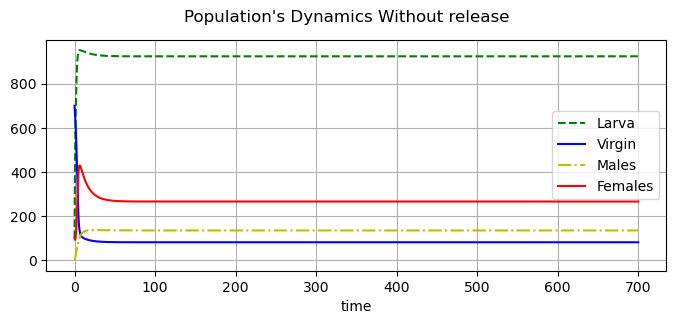

In [7]:
#Initial conditions
#males scarcity
X0_base = [100, 0, 700, 100]# L, M, V, F

#System dynamics
Mb = dynamic_rel(X0_base, Ms=0, Fs=0, name="without_SIT_semi_complexe_dynamics 4 compartement males scarcity")

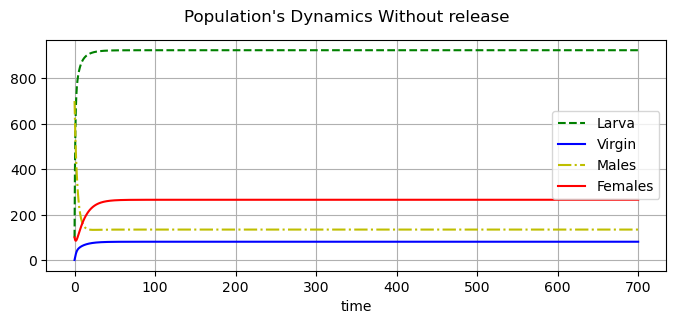

In [8]:
#Initial conditions
#males abundancy
X0_base = [100, 700, 1, 100]# L, M, V, F

#System dynamics
Mb = dynamic_rel(X0_base, Ms=0, Fs=0, name="without_SIT_semi_complexe_dynamics 4 compartement males abundancy")

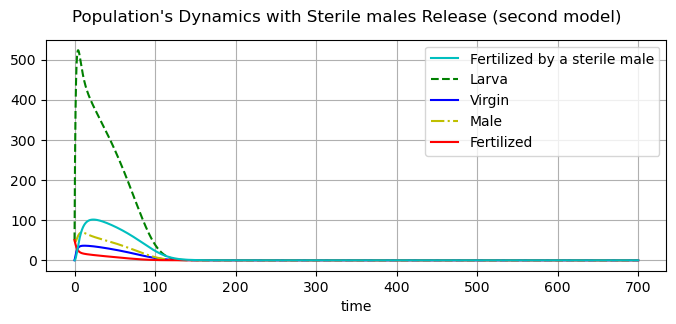

In [6]:
#initial conditions
X0_tis = [50,50,0,50,0]# L, M, V, F, S
Mb = dynamic_rel(X0_tis, Ms=500, Fs=0, name="SIT_complexe_dynamics 5 compartement males release")

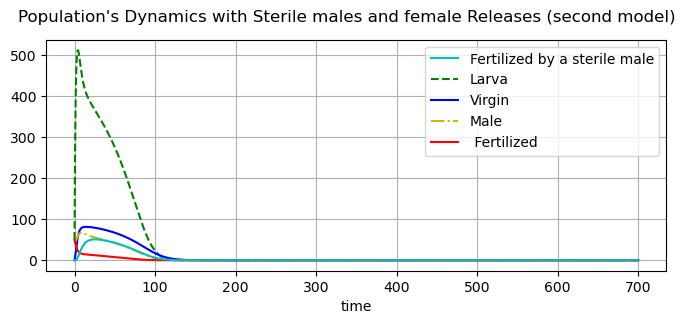

In [7]:
#initial conditions
X0_rel_tis = [50,50,0,50,0]# L, M, V, F, S
dynamic_rel(X0_rel_tis,Ms=250,Fs=250,name="releasing malesandfemales_SIT_dynamics")

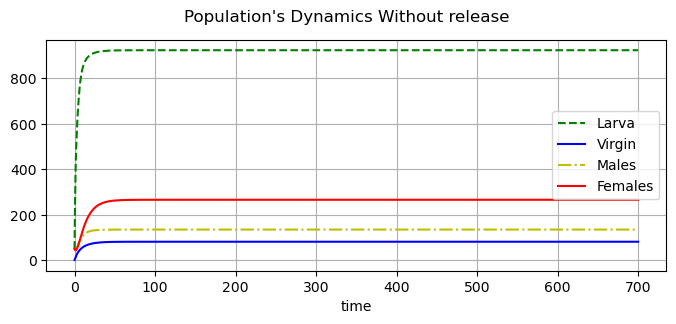

In [30]:
#initial conditions
X0_rel_tis = [50,50,1,50]# L, M, V, F
dynamic_rel(X0_rel_tis,Ms=0,Fs=0,name="dynamics")

# Equilibrium points and its stability

# 1) Second model only male releases

# Roots

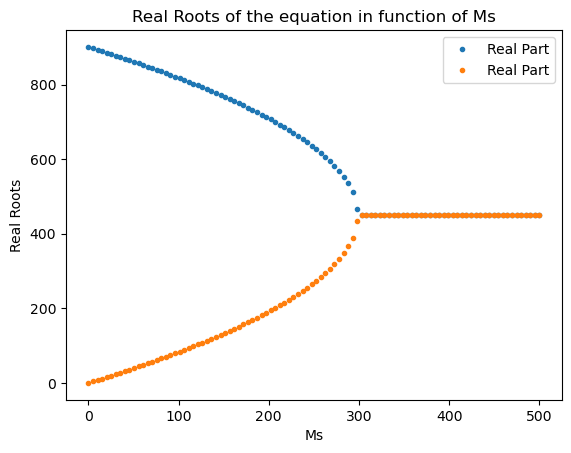

In [17]:
import numpy as np
import matplotlib.pyplot as plt



# Calculations based on the parameters
eta0 = ((1 - m) * vL * vF * b) / (uF * (uL + vL))  # Number of baseline descendants

# Generate Ms values
Ms_values = np.linspace(0, 500, 100)

# Calculate the roots for each Ms value
real_roots = []
for Ms in Ms_values:
    term1 = -(eta0 / K)
    term2 = (eta0 + delta * vF / (uF * (uF + vF)) - (uF + delta) / uF)
    term3 = - (uM * Ms / (m * vL)) * ((uF + delta) / uF - (((uF + delta) * gamma * vF) / (uF * (uF + gamma) * (uF + vF))))
    roots = np.roots([term1, term2, term3])
    real_roots.append(np.real(roots))

# Plot the real roots
plt.figure()
plt.plot(Ms_values, real_roots, '.', label='Real Part')
plt.xlabel('Ms')
plt.ylabel('Real Roots')
plt.title('Real Roots of the equation in function of Ms')
plt.legend()
plt.show()


# Equilbrium points

In [20]:
# model with only males release
from sympy import symbols, Eq, solve, re, im


################################# Males and females number 
Fs = 0
Ms = 250
##################################
# Define the symbolic variables
L, M, V, F, S = symbols('L M V F S')

# Define the equations
M_term = (M / (M + Ms)) if Ms != 0 else 1.0
Ms_term = (Ms / (M + Ms)) if Ms != 0 else 0.0

L_dot = b * (1 - (L / K)) * F - (vL + uL) * L
M_dot = m * vL * L - uM * M
V_dot = (1-m)*vL*L + delta*F + gamma*S - (uF+vF)*V
F_dot = vF*M/(M+Ms)*V - (uF+delta)*F
S_dot = vF*Ms/(M+Ms)*V - (uF+gamma)*S
# Define the system of equations
equations = [
    Eq(L_dot, 0),
    Eq(M_dot, 0),
    Eq(V_dot, 0),
    Eq(F_dot, 0),
    Eq(S_dot, 0)
]

# Solve the system of equations and obtain all solutions
solutions = solve(equations, (L, M, V, F, S)) #

# Filter out the real solutions and set small imaginary parts to zero
real_solutions = []
threshold = 1e-5

for sol in solutions:
    is_real_solution = True
    modified_sol = {}
    for var in range(0,5):
        val = sol[var]
        if im(val).evalf() > threshold:
            is_real_solution = False
            break
        elif abs(im(val).evalf()) <= threshold:
            modified_sol[var] = re(val).evalf()
    if is_real_solution:
        real_solutions.append(modified_sol)
#print(real_solutions)
# Print the real solutions
for sol in real_solutions:
    print("Equilbirum points:")
    print(f"L*: {sol[0]}")
    print(f"M*: {sol[1]}")
    print(f"V*: {sol[2]}")
    print(f"F*: {sol[3]}")
    print(f"S*: {sol[4]}")
    print()

Equilbirum points:
L*: 0
M*: 0
V*: 0
F*: 0
S*: 0

Equilbirum points:
L*: 174.986119283774
M*: 25.5402663729671
V*: 15.4075205939927
F*: 4.66916384929994
S*: 45.7039462814881

Equilbirum points:
L*: 748.542029424748
M*: 109.254167708388
V*: 65.9090948529901
F*: 65.5311145107984
S*: 149.951063390343



# Stability

In [21]:
import sympy as sm
import numpy as np
import numpy.linalg as linalg

# Convert equations to matrix form and calculate the Jacobian matrix
eqMat = sm.Matrix([L_dot, M_dot, V_dot, F_dot, S_dot])
Mat = sm.Matrix([L, M, V, F, S])
jacMat = eqMat.jacobian(Mat)
print('Jacobian matrix:\n', jacMat)

# Calculate equilibria
equilibria = real_solutions

# Iterate over the equilibria
for eq in equilibria:
    # Substitute equilibrium values into the Jacobian matrix and obtain eigenvalues
    eqmat = np.array(jacMat.subs([(L, eq[0]), (M, eq[1]), (V, eq[2]), (F, eq[3]), (S, eq[4])])).astype(np.float64)
    eigenValues, eigenVectors = linalg.eig(eqmat)

    print('-------------------------------------------')
    print("The real parts of the eigenvalues for the fixed point (%s, %s, %s, %s, %s) are:" % (eq[0], eq[1], eq[2], eq[3], eq[4]), eigenValues.real)

    # Check the sign of the real parts
    if all([d < 0 for d in eigenValues.real]):
        print("This fixed point is a sink, and the equilibrium is stable.")
    else:
        print("This fixed point is a source, and the equilibrium is unstable.")

    # Find the dominant eigenvalue (the largest absolute value)
    domEV = max([abs(x) for x in eigenValues.real])
    posdomEV = [abs(x) for x in eigenValues.real].index(domEV)
    print("The dominant eigenvalue is value %s." % (posdomEV + 1))


Jacobian matrix:
 Matrix([[-9*F/1000 - 0.198125, 0, 0, 9 - 9*L/1000, 0], [0.0390625000000000, -0.267632106286773, 0, 0, 0], [0.0390625000000000, 0, -0.770578642110031, 0.100000000000000, 0.100000000000000], [0, -0.666666666666667*M*V/(M + 250)**2 + 0.666666666666667*V/(M + 250), 0.666666666666667*M/(M + 250), -0.203911975443364, 0], [0, -166.666666666667*V/(M + 250)**2, 166.666666666667/(M + 250), 0, -0.203911975443364]])
-------------------------------------------
The real parts of the eigenvalues for the fixed point (0, 0, 0, 0, 0) are: [-0.10391198 -0.87057864 -0.26763211 -0.198125   -0.20391198]
This fixed point is a sink, and the equilibrium is stable.
The dominant eigenvalue is value 2.
-------------------------------------------
The real parts of the eigenvalues for the fixed point (174.986119283774, 25.5402663729671, 15.4075205939927, 4.66916384929994, 45.7039462814881) are: [-0.8306968  -0.38003656 -0.38003656  0.03594556 -0.13135782]
This fixed point is a source, and the equi

# Bifurcation 

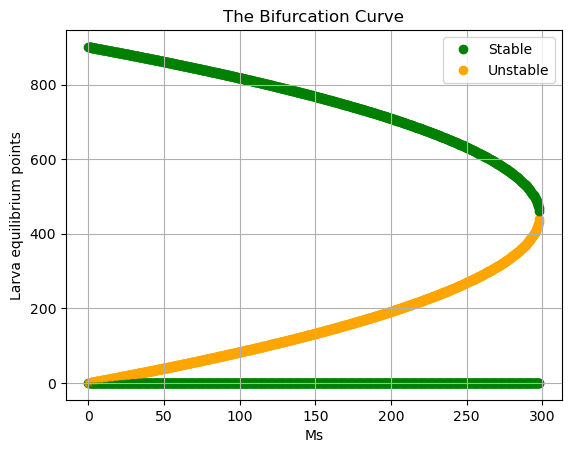

<Figure size 640x480 with 0 Axes>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols
import sympy as sm
import numpy.linalg as linalg


# Generate Ms values
Ms_values = np.linspace(0, 350, 1000)
Ms_value = []
l_values = []
stable_points = []
unstable_points = []
solution=[]
colors=[]
# Calculate the roots for each Ms value
for Ms in Ms_values:
    term1 = -(eta0 / K)
    term2 = (eta0 + delta * vF / (uF * (uF + vF)) - (uF + delta) / uF)
    term3 = - (uM * Ms / (m * vL)) * (
            (uF + delta) / uF - (((uF + delta) * gamma * vF) / (uF * (uF + gamma) * (uF + vF))))
    roots = np.roots([term1, term2, term3])
    real_roots = [root for root in roots if np.isreal(root)]

    if len(real_roots) == 0:
        break  # Exit the loop if there are no real roots
    if Ms == 0:
        l = np.zeros(2)
        if real_roots[0]<real_roots[1]:
            l[0] = real_roots[0]
            l[1] = real_roots[1]
        
        else:
            l = real_roots
        Ms_value.append(Ms)
        Ms_value.append(Ms)
        colors.append('green')
        colors.append('green')
        l=np.array(l)
        l_values.append(l)
    else:
        l = np.zeros(3)
        if real_roots[0]<real_roots[1]:
            l[1] = real_roots[0]
            l[2] = real_roots[1]
        else:
            l[1] = real_roots[1]
            l[2] = real_roots[0]
        Ms_value.append(Ms)
        Ms_value.append(Ms)
        Ms_value.append(Ms)
        colors.append('green')
        colors.append('orange')
        colors.append('green')
        l=np.array(l)
        l_values.append(l)

        for i in l:
            if i == 0:
                solution.append([0, 0, 0, 0, 0])
                
            else:
                M = m * vL * i / uM
                F = (uL + vL) * i / (b * (1 - i / K))
                S = (Ms * (uF + delta)) / (M * (uF + delta)) * F
                V = (uF + delta) / (vF) * ((M + Ms) / M) * F
                solution.append([i, M, V, F, S])
        #print(solution)
l_values=np.concatenate(l_values)
# Associate roots with equilibrium points and determine stability
L, M, V, F, S = symbols('L M V F S')
# Define the equations
M_term = (M / (M + Ms)) if Ms != 0 else 1.0
Ms_term = (Ms / (M + Ms)) if Ms != 0 else 0.0

L_dot = b * (1 - (L / K)) * F - (vL + uL) * L
M_dot = m * vL * L - uM * M
V_dot = (1 - m) * vL * L + delta * F + gamma * S - (uF + vF) * V
F_dot = vF * M / (M + Ms) * V - (uF + delta) * F
S_dot = vF * Ms / (M + Ms) * V - (uF + gamma) * S

eqMat = sm.Matrix([L_dot, M_dot, V_dot, F_dot, S_dot])
Mat = sm.Matrix([L, M, V, F, S])
jacMat = eqMat.jacobian(Mat)

for i in range(len(colors)):
    plt.scatter(Ms_value[i], l_values[i], color=colors[i])
plt.grid()
plt.xlabel('Ms')
plt.ylabel('Larva equilibrium points')
plt.title('The Bifurcation Curve')

# Create a custom legend
legend_labels = ['Stable', 'Unstable']
legend_colors = ['green', 'orange']
legend_markers = ['o', 'o']
legend_elements = [plt.Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor=color, markersize=8)
                   for marker, color, label in zip(legend_markers, legend_colors, legend_labels)]

# Add the legend
plt.legend(handles=legend_elements)

# Display the plot
plt.show()
# Export the graph
name="Bifurcation of the males release 6 compartements"
plt.savefig(output_fold+'\\'+name+'.png', dpi=300)

# Intersection
males only release 6 compartement complexe model

[631.65463767 269.10584658]


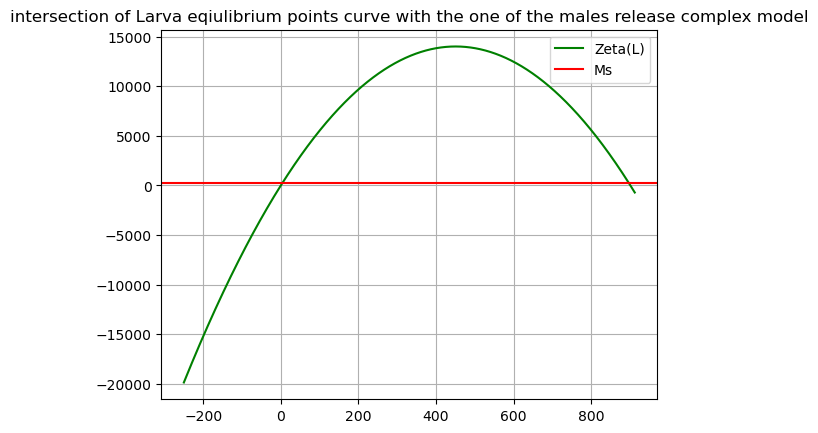

<Figure size 640x480 with 0 Axes>

In [35]:
import numpy as np 
# Parameters
# Parameters derived from the literature (see report)


######
# Calculations based on the parameters
eta0 = ((1-m) * vL*vF * b) / (uF * (uL + vL))  # Number of baseline descendants
# gamma = vL * m / uM  # The Gamma parameter of the MS parabola equation
######

# Generate L values
#L_values = np.linspace(0, 100, 1000)
Fs=0 
Ms=250
L0=0
L_max=K*(1-(1/eta0))

Ln = np.array(np.arange(-250, L_max, 0.1))  # Discretization of L values
Males = np.array([(-(eta0 / K) * L**2 + (eta0+delta*vF/(uF*(uF+vF))-(uF+delta)/uF) * L )/((m*vL/uM) * ((uF+delta)/uF-(((uF+delta)*gamma*vF)/(uF*(uF+gamma)*(uF+vF))))) for L in Ln])  # Values of MS along the parabola
#Females_prime=np.array([(-(eta0 / K) * m * (1 - m) * vL**2 * (L**2) * 3 + m * (1 - m) * vL**2 * (eta0 - 1) * L*2 - (Ms * uM * (1 - m) * vL + Fs * uF * m * vL) )/(uM*Ms*uF) for L in Ln])

term1=-(eta0 / K) 
term2= (eta0+delta*vF/(uF*(uF+vF))-(uF+delta)/uF)
term3= - (uM*Ms/(m*vL)) * ((uF+delta)/uF-(((uF+delta)*gamma*vF)/(uF*(uF+gamma)*(uF+vF))))
#term4=-Ms * Fs * uM * uF 
roots = np.roots([term1, term2, term3])
print(roots)
# Find intersection indices
intersection_indices = np.where(Males == Ms)[0]

# Extract corresponding L values
intersection_L_values = Ln[intersection_indices]
Ln_another = np.zeros_like(Ln)
# Plot the curves
plt.plot(Ln, Males, color='green', label='Zeta(L)')
plt.axhline(Ms, color='red', label='Ms')
plt.grid(True)
plt.legend()
plt.title("intersection of Larva eqiulibrium points curve with the one of the males release complex model")
plt.show()

name= 'intersection of Larva eqiulbrium points curve with the one of the males release complex model'
plt.savefig(output_fold+'\\'+name+'.png', dpi=300)
# Plot the deriviative of the curve zeta1

#plt.plot(Ln, Females_prime, color='green', label='Zeta^*(L)')
#plt.plot(Ln, Ln_another, color='red', label='zeros')
#plt.grid(True)
#plt.legend()
# Highlight the intersection points
#plt.scatter(intersection_L_values, np.full_like(intersection_L_values, Fs), color='blue', marker='*')

# Add a title


plt.show()

# 1) Second model both releases


In [25]:
import sympy as sm
import numpy as np
import numpy.linalg as linalg

# Convert equations to matrix form and calculate the Jacobian matrix
eqMat = sm.Matrix([L_dot, M_dot, V_dot, F_dot, S_dot])
Mat = sm.Matrix([L, M, V, F, S])
jacMat = eqMat.jacobian(Mat)
print('Jacobian matrix:\n', jacMat)

# Calculate equilibria
equilibria = real_solutions

# Iterate over the equilibria
for eq in equilibria:
    # Substitute equilibrium values into the Jacobian matrix and obtain eigenvalues
    eqmat = np.array(jacMat.subs([(L, eq[0]), (M, eq[1]), (V, eq[2]), (F, eq[3]), (S, eq[4])])).astype(np.float64)
    eigenValues, eigenVectors = linalg.eig(eqmat)

    print('-------------------------------------------')
    print("The real parts of the eigenvalues for the fixed point (%s, %s, %s, %s, %s) are:" % (eq[0], eq[1], eq[2], eq[3], eq[4]), eigenValues.real)

    # Check the sign of the real parts
    if all([d < 0 for d in eigenValues.real]):
        print("This fixed point is a sink, and the equilibrium is stable.")
    else:
        print("This fixed point is a source, and the equilibrium is unstable.")

    # Find the dominant eigenvalue (the largest absolute value)
    domEV = max([abs(x) for x in eigenValues.real])
    posdomEV = [abs(x) for x in eigenValues.real].index(domEV)
    print("The dominant eigenvalue is value %s." % (posdomEV + 1))

Jacobian matrix:
 Matrix([[-9*F/1000 - 0.198125, 0, 0, 9 - 9*L/1000, 0], [0.0390625000000000, -0.267632106286773, 0, 0, 0], [0.0390625000000000, 0, -0.770578642110031, 0.100000000000000, 0.100000000000000], [0, -7.48211603625779e-6*M*V/(0.00335010060362173*M + 1)**2 + 0.666666666666667*V/(M + 298.498498498498), 0.666666666666667*M/(M + 298.498498498498), -0.203911975443364, 0], [0, -0.00223340040241449*V/(0.00335010060362173*M + 1)**2, 198.998998998999/(M + 298.498498498498), 0, -0.203911975443364]])
-------------------------------------------
The real parts of the eigenvalues for the fixed point (0, 0, 0, 0, 0) are: [-0.10391198 -0.87057864 -0.26763211 -0.198125   -0.20391198]
This fixed point is a sink, and the equilibrium is stable.
The dominant eigenvalue is value 2.
-------------------------------------------
The real parts of the eigenvalues for the fixed point (174.986119283774, 25.5402663729671, 15.4075205939927, 4.66916384929994, 45.7039462814881) are: [-0.83707294 -0.37028688